In [25]:
import pandas as pd
import numpy as np
import joblib as jb
import tifffile
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_division


In [2]:
path_data = '../data/bands'

In [3]:
bands_list = [e for e in glob(str(path_data)+'/*')]
bands_list.sort()

In [4]:
bands_dict = {}
for i, e in enumerate(bands_list):
    bands_dict[f'b{i}'] = tifffile.TiffFile(e)

In [13]:
aux_dict = dict()
for page in bands_dict['b1'].pages:
    for tag in page.tags.values():
        aux_dict[tag.name] = tag.value

scale_x = aux_dict['ModelTransformationTag'][0]
scale_y = aux_dict['ModelTransformationTag'][5]
start_value_x = aux_dict['ModelTransformationTag'][3]
start_value_y = aux_dict['ModelTransformationTag'][7]

In [5]:
bands_arrays_dict = {}
for k, v in bands_dict.items():
    bands_arrays_dict[k] = v.asarray()

In [6]:
bat_path = Path('../data/bathymetry/BATIMETRIA_BRUTA_BABITONGA_2018_WGS84_UTM22S.xyz')
df_bat_data = pd.read_csv(bat_path, sep=' ', header=None)
df_bat_data.columns = ['x', 'y', 'z']
df_bat_data.head(3)

,x,y,z
0,720408.27,7089919.29,2.18
1,720408.40,7089919.18,2.27
2,720408.53,7089919.09,2.10


In [8]:
df_bat_data.describe()

,x,y,z
count,581619.000000,5.816190e+05,581619.000000
mean,730353.079262,7.095487e+06,7.461060
std,6325.838789,5.302925e+03,5.112899
min,720406.770000,7.083637e+06,0.080000
25%,725090.790000,7.091240e+06,3.400000
50%,728817.860000,7.095258e+06,6.280000
75%,735569.550000,7.099812e+06,10.120000
max,743484.100000,7.107470e+06,29.100000


<Figure size 864x432 with 0 Axes>

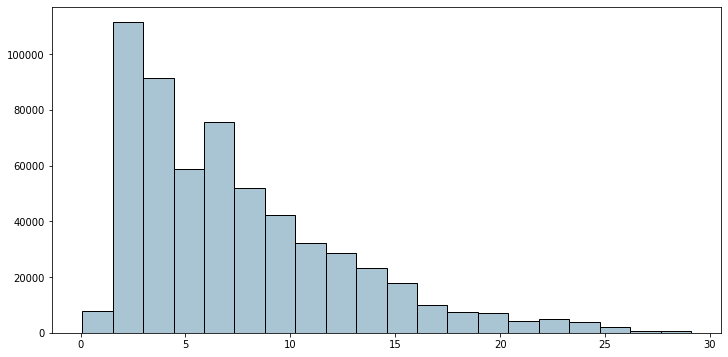

In [9]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=1, figsize=(12, 6))
_ = axs.hist(df_bat_data.z, bins=20, color='#A9C5D3', edgecolor='black')

In [10]:
df_bat_data.z.skew()

1.2061730946870155

In [11]:
np.log(df_bat_data.z).skew()

-0.11449096652832617

In [14]:
df_pixel_coord_bat_data = pd.DataFrame()

px = list()
py = list()
zlist = list()
    
for i, row in enumerate(df_bat_data.itertuples()):
    x = row[1]
    y = row[2]
    z = row[3]
    pixel = get_pixel_from_coord(x, y, scale_x, scale_y, start_value_x, start_value_y)
    px.append(pixel[0])
    py.append(pixel[1])
    zlist.append(z)

df_pixel_coord_bat_data['x'] = px
df_pixel_coord_bat_data['y'] = py
df_pixel_coord_bat_data['z'] = zlist

In [15]:
df_pixel_coord_bat_data = df_pixel_coord_bat_data[df_pixel_coord_bat_data.y > 0 ]

In [19]:
df_pixel_coord_bat_data_mean = df_pixel_coord_bat_data.groupby(['x', 'y']).mean()
df_pixel_coord_bat_data_mean.reset_index(inplace=True)

In [20]:
for k, v in bands_arrays_dict.items():
    aux = list()
    for i, row in enumerate(df_pixel_coord_bat_data_mean.itertuples()):
        px = row[1]
        py = row[2]
        aux.append(v[py][px])
    df_pixel_coord_bat_data_mean[k] = aux

In [21]:
df_pixel_coord_bat_data_mean.head(2)

,x,y,z,b0,b1,b2,b3,b4,b5,b6,b7
0,226,1010,2.117692,0.1225,0.0919,0.0721,0.0516,0.0528,0.0337,0.0311,0.0256
1,227,1010,2.096500,0.1225,0.0920,0.0712,0.0512,0.0528,0.0337,0.0311,0.0255


In [22]:
df = df_pixel_coord_bat_data_mean.copy()

In [23]:
df['b2b4'] = df[['b2', 'b4']].apply(lambda x: pixel_log_division(x.b2, x.b4), axis=1)
df['b3b4'] = df[['b3', 'b4']].apply(lambda x: pixel_log_division(x.b3, x.b4), axis=1)
df['ndwi15'] = df[['b1', 'b5']].apply(lambda x: pixel_ndwi(x.b1, x.b5), axis=1)
df['ndwi24'] = df[['b2', 'b4']].apply(lambda x: pixel_ndwi(x.b2, x.b4), axis=1)
df['ndwi53'] = df[['b5', 'b3']].apply(lambda x: pixel_ndwi(x.b5, x.b3), axis=1)
df.head()

,x,y,z,b0,b1,b2,b3,b4,b5,b6,b7,b2b4,b3b4,ndwi15,ndwi24,ndwi53
0,226,1010,2.117692,0.1225,0.0919,0.0721,0.0516,0.0528,0.0337,0.0311,0.0256,1.078543,0.994204,0.463376,0.154524,-0.209848
1,227,1010,2.096500,0.1225,0.0920,0.0712,0.0512,0.0528,0.0337,0.0311,0.0255,1.075376,0.992242,0.463803,0.148387,-0.206125
2,228,1010,2.197059,0.1221,0.0917,0.0720,0.0508,0.0531,0.0332,0.0323,0.0255,1.076655,0.988852,0.468375,0.151079,-0.209524
3,229,1010,2.268750,0.1221,0.0915,0.0726,0.0505,0.0531,0.0332,0.0323,0.0256,1.078745,0.987361,0.467522,0.155131,-0.206691
4,229,1011,2.278235,0.1221,0.0909,0.0726,0.0517,0.0531,0.0332,0.0323,0.0255,1.078745,0.993273,0.464948,0.155131,-0.217903


In [24]:
jb.dump(df, '../data/generated/df_newimages_bands_downside.pkl.z')

['../data/generated/df_newimages_bands_downside.pkl.z']